In [1]:
import torch
from torch.utils.data import TensorDataset
import torch.nn as nn
import numpy as np
import os
from tqdm.auto import tqdm


class MassMaps(TensorDataset): 
    def __init__(self, data_dir, split='train', download=False,
                 verbose=0):
        assert split in ['train', 'val', 'test']
        if download: 
            raise ValueError("download not implemented")
            
        self.data_dir = data_dir
            
        if split in ['train', 'val']: 
            X,y = [os.path.join(data_dir, f"{a}_maps_Cosmogrid_100k.npy")
                                for a in ["X", "y"]]
        elif split == 'test': 
            X,y = [os.path.join(data_dir, f"test_{a}.npy")
                                for a in ["x", "y"]]
        else: 
            raise ValueError("Split should be either train or test")
        
        X,y = [torch.from_numpy(np.load(a)) for a in (X,y)]
        X = X.unsqueeze(1).float()
        
        if split in ['train', 'val']: 
            # number of samples
            num_samples = len(y)
            # split the sample for training ----------
            train_split = int(0.80*num_samples)
            np.random.seed(42)
            train_x, val_x = np.split(X, [train_split])
            train_y, val_y = np.split(y, [train_split])
            if split == 'train':
                X, y = train_x, train_y
            else: # split == 'val'
                X, y = val_x, val_y
            params_mask = np.array([True,False,False,True,False,False])
            y = y[:, params_mask]
        
        if verbose >= 1:
            print(f'# samples used for {split}:', len(y))
        
        super(MassMaps,self).__init__(X,y)

        
class MassMapsConvnet(nn.Module):
    def __init__(self, output_num=2, data_dir=None):
        super(MassMapsConvnet, self).__init__()
        
        # self.normalization = nn.BatchNorm2d(1)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.relu1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(32, 48, kernel_size=4)
        self.relu3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1200, 128)
        self.relu4 = nn.LeakyReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu5 = nn.LeakyReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu6 = nn.LeakyReLU()
        self.fc4 = nn.Linear(32, output_num)
        
        if data_dir is not None:
            weights_path = os.path.join(data_dir, 'CNN_mass_maps.pth')
            self.load_state_dict(torch.load(weights_path))
            print(f'Weights loaded from {weights_path}')
        
    def forward(self, x):
        # x = self.normalization(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        return x


In [19]:
from skimage.segmentation import watershed, quickshift
from scipy import ndimage
from skimage.feature import peak_local_max
import sys
sys.path.append('../src')
from exlib.explainers.common import convert_idx_masks_to_bool

class MassMapsWatershed(nn.Module):
    def apply_watershed(self, image, compactness=0):
        image = (image * 255).astype(np.uint8)
        distance = ndimage.distance_transform_edt(image)
        coords = peak_local_max(distance, min_distance=10, labels=image)
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(mask)
        raw_labels = watershed(-distance, markers, mask=image,
                               compactness=compactness)
        return raw_labels
    
    def forward(self, images):
        """
        input: images (N, C=1, H, W)
        output: daf_preds (N, H, W)
        """
        daf_preds = []
        for image in images:
            segment_mask = torch.tensor(self.apply_watershed(image[0].numpy()))
            masks_bool = convert_idx_masks_to_bool(segment_mask[None])
            daf_preds.append(masks_bool)
        return daf_preds

In [6]:
data_dir = '/shared_data0/weiqiuy/datasets/cosmogrid'
train_dataset = MassMaps(data_dir, split='train', verbose=1)
test_dataset = MassMaps(data_dir, split='val', verbose=1)
test_dataset = MassMaps(data_dir, split='test', verbose=1)

# samples used for train: 80000
# samples used for val: 20000
# samples used for test: 10000


In [7]:
X, y = train_dataset[0]

In [8]:
X.shape, y.shape

(torch.Size([1, 66, 66]), torch.Size([2]))

In [9]:
from torch.utils.data import DataLoader

# Parameters
batch_size = 64  # You can adjust the batch size according to your computational resources
shuffle_train = True  # Shuffle the training dataset for better training
shuffle_val_test = False  # No need to shuffle the validation and test datasets

# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_val_test, 
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_val_test, 
                         num_workers=4, pin_memory=True)

# Example usage:
for images, labels in train_loader:
    # Here you can train your model
    pass


In [10]:
images.shape, labels.shape

(torch.Size([64, 1, 66, 66]), torch.Size([64, 2]))

In [20]:
watershed_dafer = MassMapsWatershed()

In [22]:
watershed_dafs = watershed_dafer(images)

In [23]:
len(watershed_dafs), watershed_dafs[0].shape

(64, torch.Size([79, 66, 66]))

In [24]:
len(watershed_dafs), watershed_dafs[1].shape

(64, torch.Size([73, 66, 66]))

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MassMapsConvnet(data_dir=data_dir).to(device)

Weights loaded from /shared_data0/weiqiuy/datasets/cosmogrid/CNN_mass_maps.pth


In [26]:
output = model(images.to(device))
output.shape

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


torch.Size([64, 2])

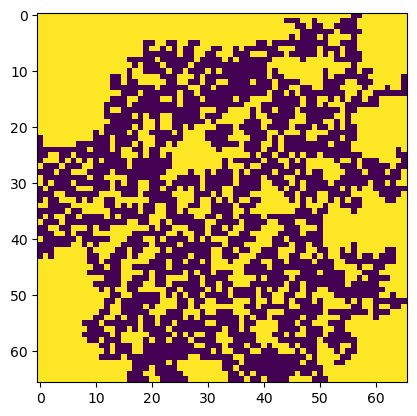

In [28]:
import matplotlib.pyplot as plt

plt.imshow(watershed_dafs[0][0].cpu())

In [51]:
class MassMapsMetrics(nn.Module):
    def __init__(self, void_threshold=0, cluster_threshold=3):
        super().__init__()
        self.void_threshold = void_threshold
        self.cluster_threshold = cluster_threshold
        self.daf_types = ['void', 'cluster']
        self.daf_types2id = {
            'void': 0,
            'cluster': 1
        }
        
    def forward(self, daf_preds, X):
        """
        daf_preds: list of N tensors (M, H, W)
        X: image (N, M, H, W)
        """
        res = []
        for daf_masks, img in zip(daf_preds, X):
            daf_types = []
            # todo: optimize
            for daf_mask in daf_masks:
                masked_img = img * daf_mask.float()
                mask_intensity = (masked_img.squeeze()[(daf_mask > 1e-4)].mean()).item()
                sigma = img.std().item()
                if mask_intensity < self.void_threshold * sigma:
                    daf_type = self.daf_types2id['void']
                elif mask_intensity > self.cluster_threshold * sigma:
                    daf_type = self.daf_types2id['cluster']
                else:
                    daf_type = -1
                daf_types.append(daf_type)
            res.append(daf_types)
        return res

In [52]:
massmaps_metrics = MassMapsMetrics()

In [53]:
results = massmaps_metrics(watershed_dafs, images)

In [56]:
results

[[-1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  0],
 [0,
  0,
  0,
  -1,
  -1,
  -1,
  -1,
  -1,
  0,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  0,
  1,
  -1,
  0,
  -1,
  -1,
  -1,
  -1,
  0,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  0,
  0,
  0,
  -1,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  0],
 [0,
  -1,
  0,
  -1,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  0,
  0,
  0,
  -1,
  -1,
  -1,
  0,
  -1,
  0,
  0,
  -1,
  0,
  -1,
  